## Librerias

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report


## Carga de datos

In [3]:
from keras.src.utils import image_dataset_from_directory

# Directorios base
train_dir = "../data/raw/train"
test_dir = "../data/raw/test"

# Dataset de entrenamiento (80%) y validación (20%)
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Dataset de prueba
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32
)

class_names = train_ds.class_names
print("Clases detectadas:", class_names)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Clases detectadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalización y Data Augmentation

In [4]:
# Reinicia el kernel si ya habías mapeado antes
# (Ctrl+Shift+P → Restart Kernel)

# Augmentación ligera (solo cambios realistas)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.05)
])

# Normalización a rango [0,1]
normalization_layer = layers.Rescaling(1./255)

# Aplicar en orden correcto
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


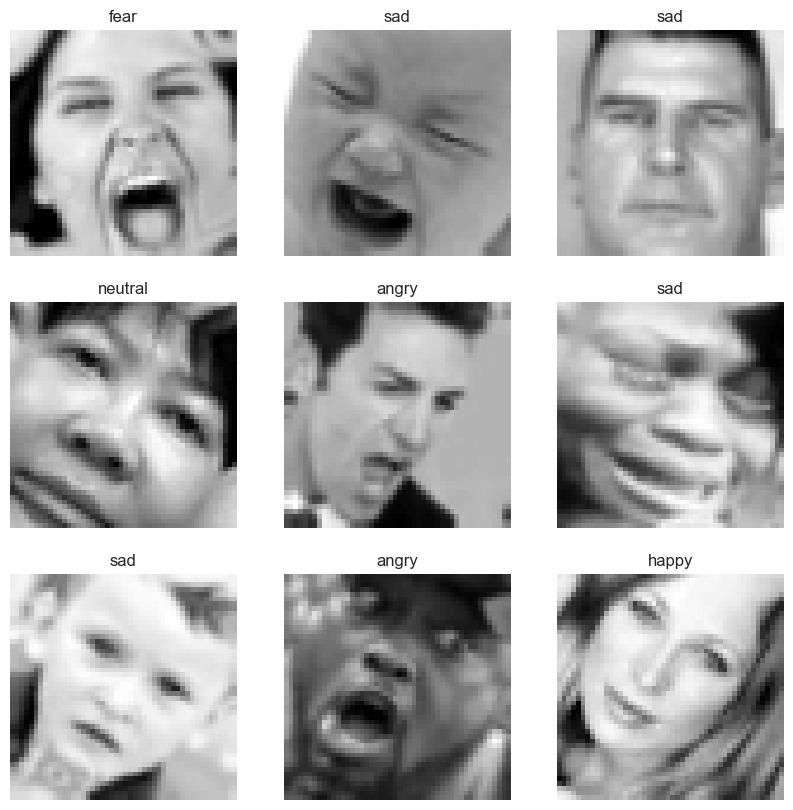

In [5]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


## Definición del modelo CNN

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


C:\Users\nigger\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Entrenamiento con Early Stopping

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2501 - loss: 1.8067 - val_accuracy: 0.2958 - val_loss: 1.7227
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.2890 - loss: 1.7385 - val_accuracy: 0.3182 - val_loss: 1.6557
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3343 - loss: 1.6616 - val_accuracy: 0.3550 - val_loss: 1.5985
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3811 - loss: 1.5782 - val_accuracy: 0.4534 - val_loss: 1.4357
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4098 - loss: 1.5167 - val_accuracy: 0.4684 - val_loss: 1.4053
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4250 - loss: 1.4888 - val_accuracy: 0.4875 - val_loss: 1.3633
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4368 - loss: 1.4598 - val_accuracy: 0.4909 - val_loss: 1.3464
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4506 - loss: 1.4339 - 

## Visualización de resultados

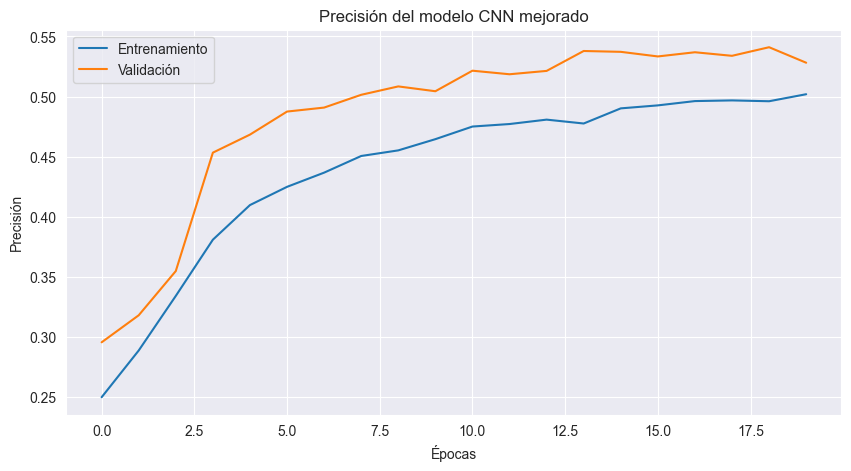

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo CNN mejorado")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

## Modelo mejorado: Transfer Learning con MobileNetV2


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar MobileNetV2 preentrenada (sin las capas finales de clasificación)
base_model = MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar las capas base (no se reentrenan)
base_model.trainable = False

base_model.summary()


C:\Users\nigger\AppData\Local\Temp\ipykernel_10756\2397476756.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Preparar los datasets para MobileNetV2

In [14]:
train_ds_rgb = image_dataset_from_directory(
    "../data/raw/train",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds_rgb = image_dataset_from_directory(
    "../data/raw/train",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds_rgb = image_dataset_from_directory(
    "../data/raw/test",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32
)

class_names = train_ds_rgb.class_names
print("Clases detectadas:", class_names)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Clases detectadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalización y optimización

In [15]:
normalization_layer = layers.Rescaling(1./255)

train_ds_rgb = train_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
val_ds_rgb = val_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
test_ds_rgb = test_ds_rgb.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds_rgb = train_ds_rgb.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_rgb = val_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)


### Definición del modelo con MobileNetV2
Se añade una capa de *Global Average Pooling* seguida de una capa *Dense* intermedia y una capa de salida con activación `softmax` para clasificar las emociones.


In [16]:
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model_tl.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compilación y entrenamiento con EarlyStopping

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='mejor_modelo_mobile.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_tl = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=40,
    callbacks=[callback]
)


Epoch 1/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.3140 - loss: 1.7257 - val_accuracy: 0.3618 - val_loss: 1.6171
Epoch 2/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.3626 - loss: 1.6201 - val_accuracy: 0.3672 - val_loss: 1.5985
Epoch 3/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.3863 - loss: 1.5663 - val_accuracy: 0.3829 - val_loss: 1.5789
Epoch 4/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.4080 - loss: 1.5193 - val_accuracy: 0.3848 - val_loss: 1.5685
Epoch 5/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.4252 - loss: 1.4773 - val_accuracy: 0.3898 - val_loss: 1.5594
Epoch 6/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.4471 - loss: 1.4287 - val_accuracy: 0.3984 - val_loss: 1.5641
Epoch 7/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.4614 - loss: 1.3884 - val_accuracy: 0.3973 - val_loss: 1.5602
Epoch 8/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.4827 - loss: 1.3403 - 

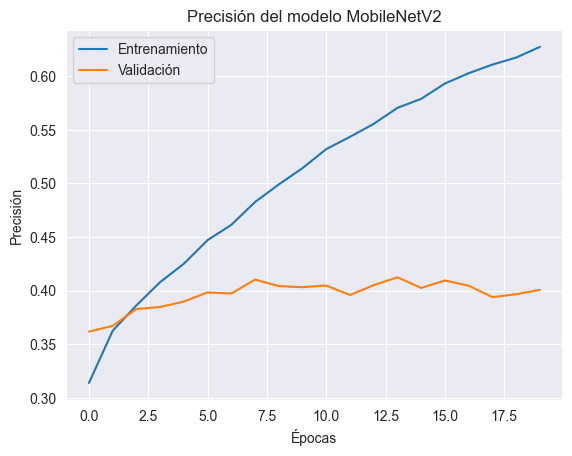

In [18]:
plt.plot(history_tl.history['accuracy'])
plt.plot(history_tl.history['val_accuracy'])
plt.title('Precisión del modelo MobileNetV2')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()


## Fine-Tuning controlado del modelo MobileNetV2

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar el modelo base preentrenado sin la parte superior
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar las capas base (no se actualizan durante el entrenamiento inicial)
base_model.trainable = False

# Construcción del modelo nuevo
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  #
])

# Compilar el modelo
model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento inicial con EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Redimensionar las imágenes a 224x224 para MobileNetV2
resize_layer = tf.keras.layers.Resizing(224, 224)

train_ds_rgb = train_ds_rgb.map(lambda x, y: (resize_layer(x), y))
val_ds_rgb = val_ds_rgb.map(lambda x, y: (resize_layer(x), y))
test_ds_rgb = test_ds_rgb.map(lambda x, y: (resize_layer(x), y))


history_tl = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,     
    epochs=20,
    callbacks=[callback]
)


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 233s 321ms/step - accuracy: 0.3667 - loss: 1.6184 - val_accuracy: 0.4365 - val_loss: 1.4489
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 232s 323ms/step - accuracy: 0.4232 - loss: 1.4983 - val_accuracy: 0.4625 - val_loss: 1.4058
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 232s 323ms/step - accuracy: 0.4433 - loss: 1.4502 - val_accuracy: 0.4835 - val_loss: 1.3876
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 236s 328ms/step - accuracy: 0.4588 - loss: 1.4152 - val_accuracy: 0.4949 - val_loss: 1.3368
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 240s 335ms/step - accuracy: 0.4683 - loss: 1.3897 - val_accuracy: 0.4966 - val_loss: 1.3220
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 234s 326ms/step - accuracy: 0.4731 - loss: 1.3700 - val_accuracy: 0.4957 - val_loss: 1.3118
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 235s 328ms/step - accuracy: 0.4781 - loss: 1.3526 - val_accuracy: 0.5025 - val_loss: 1.3157
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 235s 327ms/step - accuracy: 0.4841 -

In [20]:
 # Guardar el modelo completo (estructura + pesos + compilación)
model_tl.save("modelo_mobilenetv2_final.h5")

print("Modelo guardado exitosamente como 'modelo_mobilenetv2_final.h5'")

model_tl.save("modelo_mobilenetv2_final.keras")
print("Modelo guardado también en formato moderno .keras")



Modelo guardado exitosamente como 'modelo_mobilenetv2_final.h5'
Modelo guardado también en formato moderno .keras


## Fine-Tuning controlado del modelo MobileNetV2

Hasta ahora el modelo MobileNetV2 se entrenó con la base congelada, lo cual permitió
ajustar únicamente las capas densas finales.  
A continuación, se realiza un *fine-tuning* controlado, descongelando las últimas capas
de la MobileNetV2 para refinar el aprendizaje sobre el dataset de emociones.


In [21]:
# Descongelar las últimas capas de la MobileNetV2
base_model.trainable = True

# Solo entrenar las últimas 50 capas para evitar sobreajuste
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compilar con un learning rate muy bajo para no destruir los pesos preentrenados
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento fino (Fine-Tuning)
history_finetune = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10,
    callbacks=[callback]
)


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 343s 467ms/step - accuracy: 0.3725 - loss: 1.6580 - val_accuracy: 0.5030 - val_loss: 1.3971
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 334s 465ms/step - accuracy: 0.4696 - loss: 1.3673 - val_accuracy: 0.5097 - val_loss: 1.3273
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 335s 467ms/step - accuracy: 0.5126 - loss: 1.2472 - val_accuracy: 0.5201 - val_loss: 1.2781
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 338s 470ms/step - accuracy: 0.5550 - loss: 1.1368 - val_accuracy: 0.5287 - val_loss: 1.2588
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 340s 474ms/step - accuracy: 0.5852 - loss: 1.0522 - val_accuracy: 0.5367 - val_loss: 1.2565
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 342s 476ms/step - accuracy: 0.6103 - loss: 0.9712 - val_accuracy: 0.5506 - val_loss: 1.2365
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 342s 476ms/step - accuracy: 0.6418 - loss: 0.8989 - val_accuracy: 0.5492 - val_loss: 1.2455
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 343s 477ms/step - accuracy: 0.6705 -

In [22]:
model_tl.save("modelo_mobilenetv2_finetuned.keras")
print("Modelo guardado en formato moderno .keras")



Modelo guardado en formato moderno .keras


## Evaluar desempeño del modelo en test

In [25]:
plt.style.use("seaborn-v0_8-whitegrid")

REPORT_DIR = os.path.join("..", "report")
MODELS_DIR = os.path.join("..", "models")
TRAIN_DIR = os.path.join("..", "data", "raw", "train")

os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Clases por orden alfabético de carpetas
CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])

In [26]:
def plot_history(history, title_prefix, out_prefix):
    if history is None or not hasattr(history, "history"):
        return
    h = history.history

    if "accuracy" in h and "val_accuracy" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["accuracy"], label="train")
        plt.plot(h["val_accuracy"], label="val")
        plt.title(f"{title_prefix} · accuracy")
        plt.xlabel("Épocas"); plt.ylabel("Accuracy"); plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(REPORT_DIR, f"{out_prefix}_accuracy.png"), dpi=150)
        plt.show()

    if "loss" in h and "val_loss" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["loss"], label="train")
        plt.plot(h["val_loss"], label="val")
        plt.title(f"{title_prefix} · loss")
        plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(REPORT_DIR, f"{out_prefix}_loss.png"), dpi=150)
        plt.show()

def predict_labels(model, dataset):
    y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)
    y_pred = []
    for x, _ in dataset:
        probs = model.predict(x, verbose=0)
        y_pred.append(np.argmax(probs, axis=1))
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names, title, out_name):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, out_name), dpi=150)
    plt.show()

def display_classification_report(y_true, y_pred, class_names, prefix):
    rep_txt = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    rep_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    df = pd.DataFrame(rep_dict).T

    # Guardar
    with open(os.path.join(REPORT_DIR, f"{prefix}_classification_report.txt"), "w", encoding="utf-8") as f:
        f.write(rep_txt)
    df.to_csv(os.path.join(REPORT_DIR, f"{prefix}_classification_report.csv"), encoding="utf-8")

    # Mostrar compacto
    display(df.style.background_gradient(cmap="Greens").format(precision=4))

def show_sample_predictions(model, dataset, class_names, prefix, max_show=16):
    for images, labels in dataset.take(1):
        preds = np.argmax(model.predict(images, verbose=0), axis=1)
        n = min(max_show, images.shape[0])
        cols = 4
        rows = int(np.ceil(n/cols))
        plt.figure(figsize=(cols*3, rows*3))
        for i in range(n):
            plt.subplot(rows, cols, i+1)
            img = images[i].numpy()
            if img.shape[-1] == 1:
                plt.imshow(img.squeeze(), cmap="gray")
            else:
                plt.imshow(np.clip(img, 0, 1))
            true_c = class_names[int(labels[i])]
            pred_c = class_names[int(preds[i])]
            color = "green" if true_c == pred_c else "red"
            plt.title(f"T:{true_c}\nP:{pred_c}", color=color, fontsize=9)
            plt.axis("off")
        plt.suptitle(f"Ejemplos · {prefix}", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(REPORT_DIR, f"{prefix}_sample_predictions.png"), dpi=150)
        plt.show()
        break

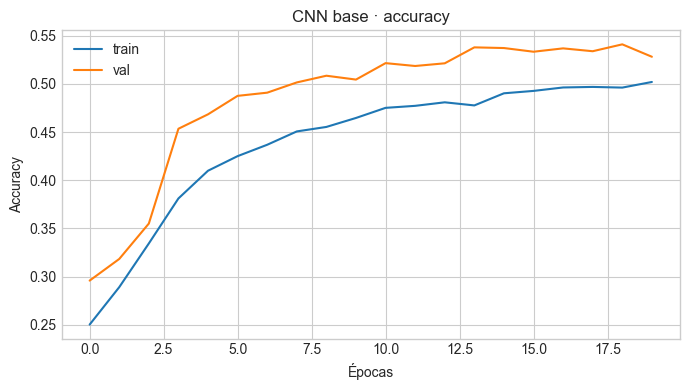

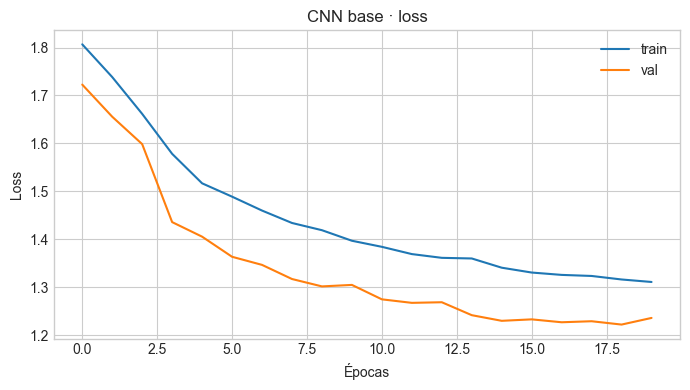

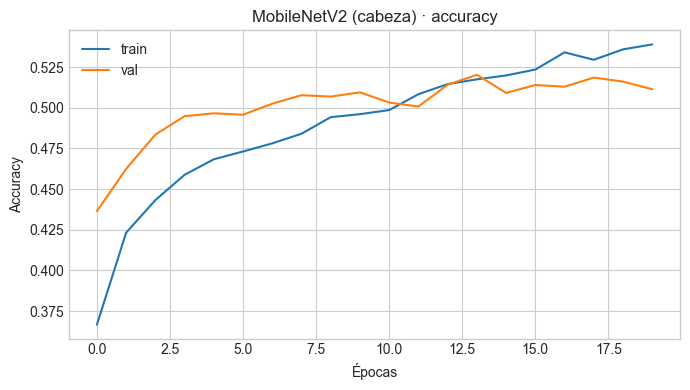

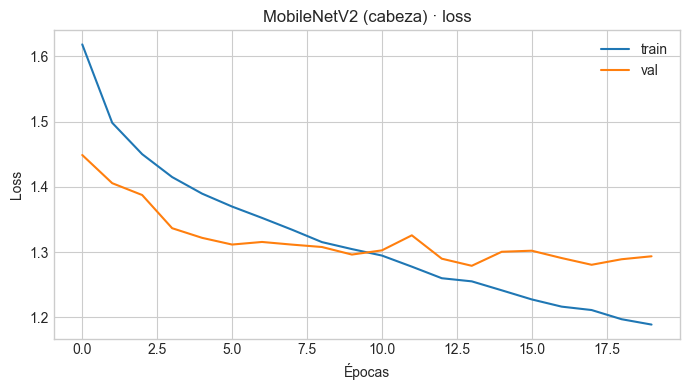

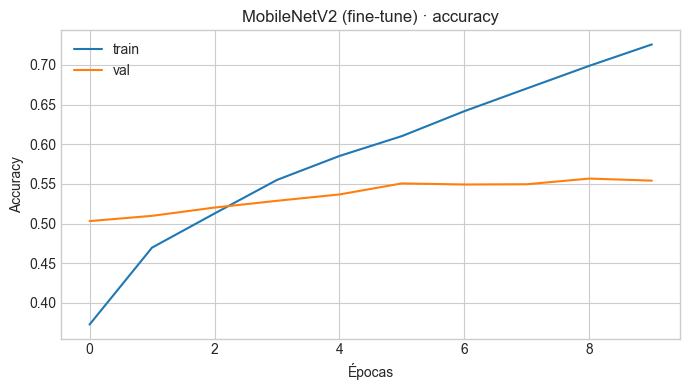

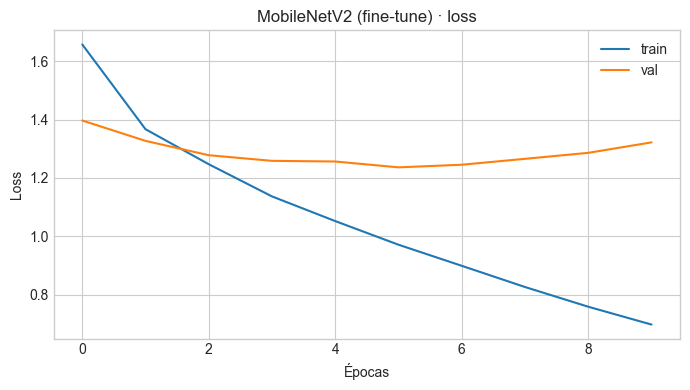

In [27]:
plot_history(globals().get("history", None), "CNN base", "cnn_base")
plot_history(globals().get("history_tl", None), "MobileNetV2 (cabeza)", "mobilenet_head")
plot_history(globals().get("history_finetune", None), "MobileNetV2 (fine-tune)", "mobilenet_ft")

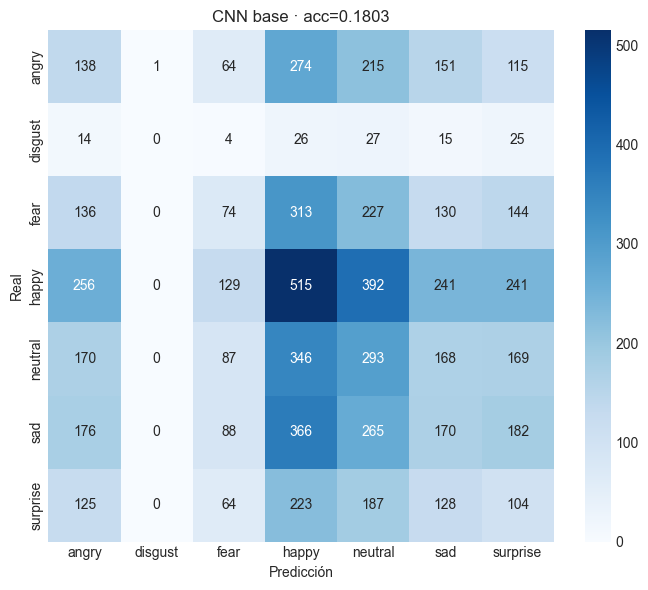

,precision,recall,f1-score,support
angry,0.1360,0.1441,0.1399,958.0000
disgust,0.0000,0.0000,0.0000,111.0000
fear,0.1451,0.0723,0.0965,1024.0000
happy,0.2496,0.2903,0.2684,1774.0000
neutral,0.1824,0.2376,0.2064,1233.0000
sad,0.1695,0.1363,0.1511,1247.0000
surprise,0.1061,0.1252,0.1149,831.0000
accuracy,0.1803,0.1803,0.1803,0.1803
macro avg,0.1412,0.1437,0.1396,7178.0000
weighted avg,0.1736,0.1803,0.1738,7178.0000


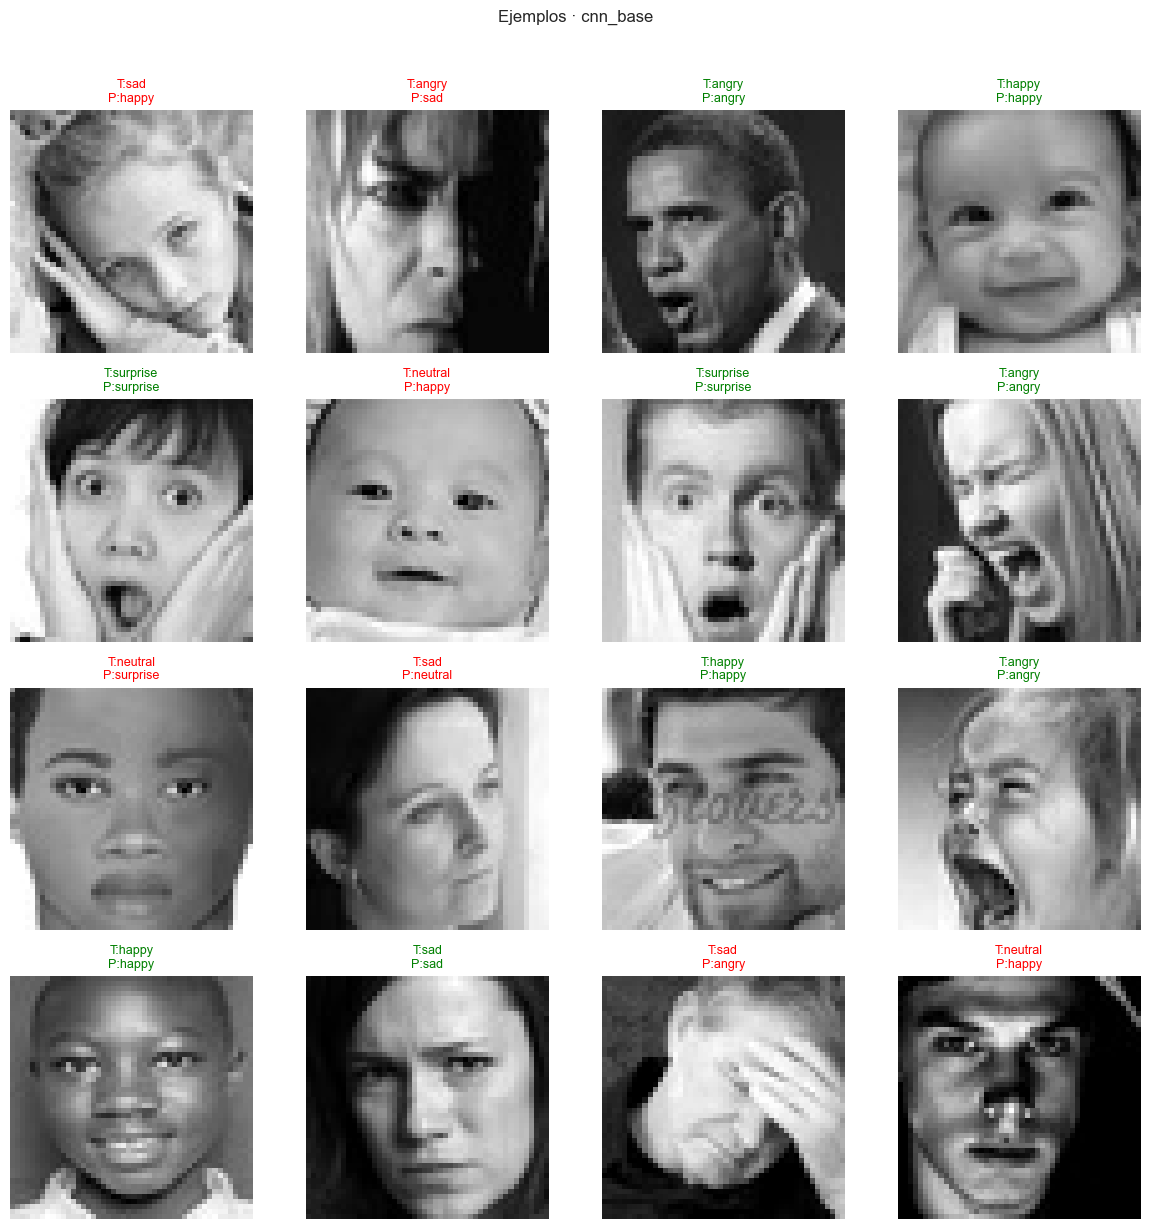

[CNN base] Test accuracy: 0.1803


In [28]:
y_true_cnn, y_pred_cnn = predict_labels(model, test_ds)
acc_cnn = float((y_true_cnn == y_pred_cnn).mean())
plot_confusion_matrix(y_true_cnn, y_pred_cnn, CLASS_NAMES, f"CNN base · acc={acc_cnn:.4f}", "cnn_base_confusion_matrix.png")
display_classification_report(y_true_cnn, y_pred_cnn, CLASS_NAMES, "cnn_base")
show_sample_predictions(model, test_ds, CLASS_NAMES, "cnn_base")
print(f"[CNN base] Test accuracy: {acc_cnn:.4f}")

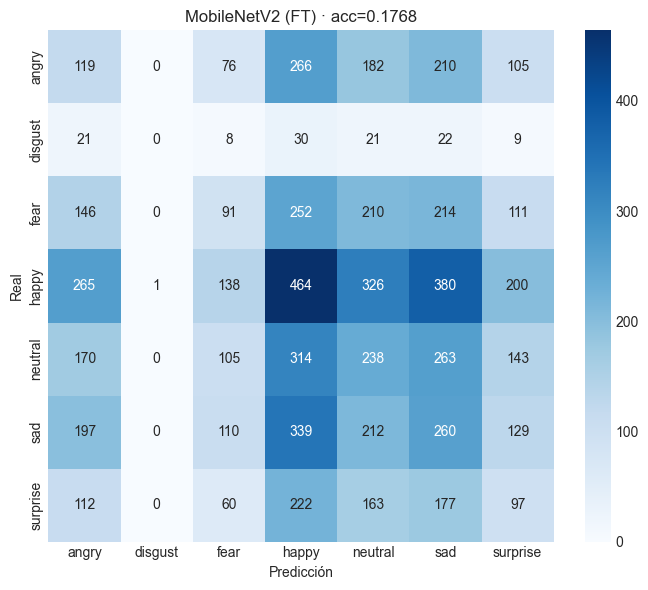

,precision,recall,f1-score,support
angry,0.1155,0.1242,0.1197,958.0000
disgust,0.0000,0.0000,0.0000,111.0000
fear,0.1548,0.0889,0.1129,1024.0000
happy,0.2459,0.2616,0.2535,1774.0000
neutral,0.1760,0.1930,0.1841,1233.0000
sad,0.1704,0.2085,0.1875,1247.0000
surprise,0.1222,0.1167,0.1194,831.0000
accuracy,0.1768,0.1768,0.1768,0.1768
macro avg,0.1407,0.1418,0.1396,7178.0000
weighted avg,0.1722,0.1768,0.1728,7178.0000


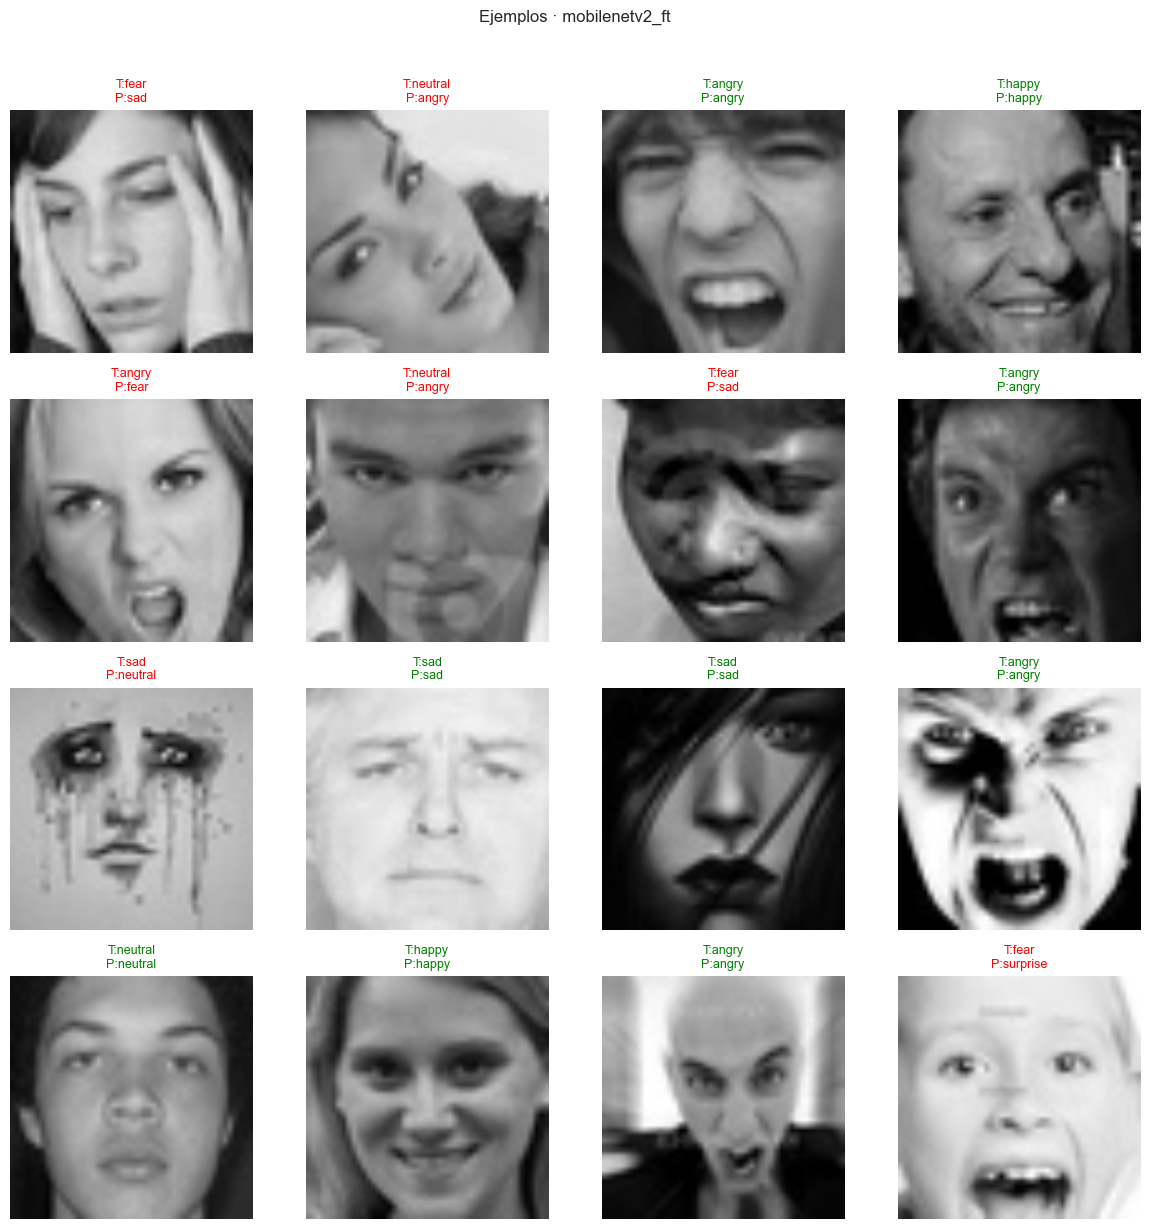

[MobileNetV2 (FT)] Test accuracy: 0.1768


In [29]:
y_true_tl, y_pred_tl = predict_labels(model_tl, test_ds_rgb)
acc_tl = float((y_true_tl == y_pred_tl).mean())
plot_confusion_matrix(y_true_tl, y_pred_tl, CLASS_NAMES, f"MobileNetV2 (FT) · acc={acc_tl:.4f}", "mobilenetv2_ft_confusion_matrix.png")
display_classification_report(y_true_tl, y_pred_tl, CLASS_NAMES, "mobilenetv2_ft")
show_sample_predictions(model_tl, test_ds_rgb, CLASS_NAMES, "mobilenetv2_ft")
print(f"[MobileNetV2 (FT)] Test accuracy: {acc_tl:.4f}")

In [30]:
resumen = pd.DataFrame(
    {"modelo": ["CNN base", "MobileNetV2 (FT)"], "test_accuracy": [acc_cnn, acc_tl]}
).sort_values("test_accuracy", ascending=False)
display(resumen.style.background_gradient(cmap="Blues").format({"test_accuracy":"{:.4f}"}))

,modelo,test_accuracy
0,CNN base,0.1803
1,MobileNetV2 (FT),0.1768


In [32]:
model_tl.save(os.path.join(MODELS_DIR, "modelo_mobilenetv2_finetuned.keras"))

converter = tf.lite.TFLiteConverter.from_keras_model(model_tl)
tflite_model = converter.convert()
with open(os.path.join(MODELS_DIR, "modelo_mobilenetv2_finetuned.tflite"), "wb") as f:
    f.write(tflite_model)

# Guarda las clases usadas
pd.Series(CLASS_NAMES).to_csv(os.path.join(MODELS_DIR, "class_names.csv"), index=False, header=False)

print("Modelos y clases guardados en '../models' y reportes en '../report'.")

INFO:tensorflow:Assets written to: C:\Users\nigger\AppData\Local\Temp\tmpzxycw561\assets


INFO:tensorflow:Assets written to: C:\Users\nigger\AppData\Local\Temp\tmpzxycw561\assets


Saved artifact at 'C:\Users\nigger\AppData\Local\Temp\tmpzxycw561'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_336')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2074818039440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818035792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2076574115088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818050384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818037712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818037328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818050960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818050768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818051152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2074818037904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargar el modelo fine-tuned
model_path = "../models/modelo_mobilenetv2_finetuned.keras"
model = tf.keras.models.load_model(model_path)

# Generador de test (sin shuffle para mantener el orden)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = "../data/raw/test"

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7178 images belonging to 7 classes.


In [7]:
import sys
!{sys.executable} -m pip install Pillow

  Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl.metadata (9.0 kB)
Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl (7.0 MB)


In [ ]:
# IMPORTS

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import cv2
import os

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # CRÍTICO: Habilitar crecimiento de memoria para 4GB VRAM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU detectada: {gpus[0].name}")
        print("✅ Crecimiento de memoria habilitado (4GB VRAM)")
    except RuntimeError as e:
        print(f"⚠️ Error configurando GPU: {e}")
else:
    print("⚠️ No se detectó GPU. Usando CPU")

print("=" * 60)

# FUNCIÓN PSEUDO-RGB SEGURA 

def pseudo_rgb(img):
    """
    Convierte imagen a pseudo-RGB manteniendo información de escala de grises
    """
    # Asegurar que esté en float32 en rango 0–1
    if img.dtype != np.float32:
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img /= 255.0

    # Convertir a escala de grises si tiene 3 canales
    if img.ndim == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
    else:
        gray = img

    # Crear pseudo-RGB (manteniendo rango 0–1)
    c1 = gray
    c2 = np.clip(gray * 0.9, 0, 1)
    c3 = np.clip(gray * 1.1, 0, 1)
    img_color = np.stack([c1, c2, c3], axis=-1).astype(np.float32)
    return img_color

# DIRECTORIOS 

train_dir = "../data/raw/train"
test_dir = "../data/raw/test"

# GENERADORES DE DATOS OPTIMIZADOS

# Batch size optimizado para RTX 3050 (4GB VRAM)
BATCH_SIZE = 32  # Si da error de memoria, reduce a 16

train_datagen = ImageDataGenerator(
    preprocessing_function=pseudo_rgb,  # Ya hace el rescaling internamente
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=pseudo_rgb,
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    preprocessing_function=pseudo_rgb,
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    test_dir,  # usa val_dir si tienes uno separado
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nDataset cargado:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Classes: {list(train_generator.class_indices.keys())}")

# MODELO TRANSFER LEARNING

print("\n Construyendo modelo MobileNetV2...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Estrategia de congelamiento
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 emociones
])

model_tl.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo construido exitosamente")
print(f"   Total parámetros: {model_tl.count_params():,}")
print(f"   Parámetros entrenables: {sum([tf.size(w).numpy() for w in model_tl.trainable_weights]):,}")

# CALLBACKS

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.3, 
        patience=2, 
        verbose=1
    ),
    ModelCheckpoint(
        '../models/modelo_mobilenetv2_pseudorgb.keras', 
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

# ENTRENAMIENTO EN GPU

print("\n" + "=" * 60)
print("INICIANDO ENTRENAMIENTO EN GPU RTX 3050")
print("=" * 60)
print(f"Tiempo estimado: ~5-15 minutos (vs ~2-4 horas en CPU)")
print("=" * 60 + "\n")

history = model_tl.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# EVALUACIÓN FINAL

print("\n" + "=" * 60)
print("EVALUACIÓN FINAL EN TEST SET")
print("=" * 60)

test_loss, test_acc = model_tl.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

# Guardar modelo final
model_tl.save("../models/modelo_mobilenetv2_pseudorgb_final.keras")
print("\n Modelo guardado correctamente en ../models/modelo_mobilenetv2_pseudorgb_final.keras")

print("\n" + "=" * 60)
print("ENTRENAMIENTO COMPLETADO")
print("=" * 60)
print(f" GPU utilizada: {gpus[0].name if gpus else 'CPU'}")
print(f"Accuracy final: {test_acc:.2%}")
print("=" * 60)

🚀 CONFIGURACIÓN DE GPU
✅ GPU detectada: /physical_device:GPU:0
✅ Crecimiento de memoria habilitado (4GB VRAM)
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

📊 Dataset cargado:
   Training samples: 28709
   Validation samples: 7178
   Batch size: 32
   Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

🔨 Construyendo modelo MobileNetV2...
✅ Modelo construido exitosamente
   Total parámetros: 2,266,951
   Parámetros entrenables: 1,870,407

🚀 INICIANDO ENTRENAMIENTO EN GPU RTX 3050
⏱️  Tiempo estimado: ~5-15 minutos (vs ~2-4 horas en CPU)

Epoch 1/25
898/898 [==============================] - ETA: 0s - loss: 1.7290 - accuracy: 0.3064
Epoch 1: val_accuracy improved from -inf to 0.13346, saving model to ../models\modelo_mobilenetv2_pseudorgb.keras
898/898 [==============================] - 330s 363ms/step - loss: 1.7290 - accuracy: 0.3064 - val_loss: 2.1889 - val_accuracy: 0.1335 - lr